<i><b><span style="color:#e74c3c;"> Note: Of course, there are other models better than my model in respect of the classification metrics, but I tried to a basic implementation of a paper. </span> </b></i>


First of all, I am very keen on trying new methods. This is why I tried <b>a Future Extractor with Feature Fusion method</b> in this project. I impressed an article named "HCF: A Hybrid CNN Framework for Behavior Detection of Distracted Drivers" in this project [1]. In this technique, first I used 2 pretrained models (EfficientNet v2 and MobileNet v2). At this stage, the 2 models are concatenated with feature outputs (as in the article). Then a dense layer for reducing the dimension as the model output. Finally, I applied PCA and classified with an SVC model. In conclusion, there is a lightly improvement in respect of the model's accuracy and F1 score. 

**I tried to fine-tune the models, but there is no considerable betterment in respect of the F1 score.**



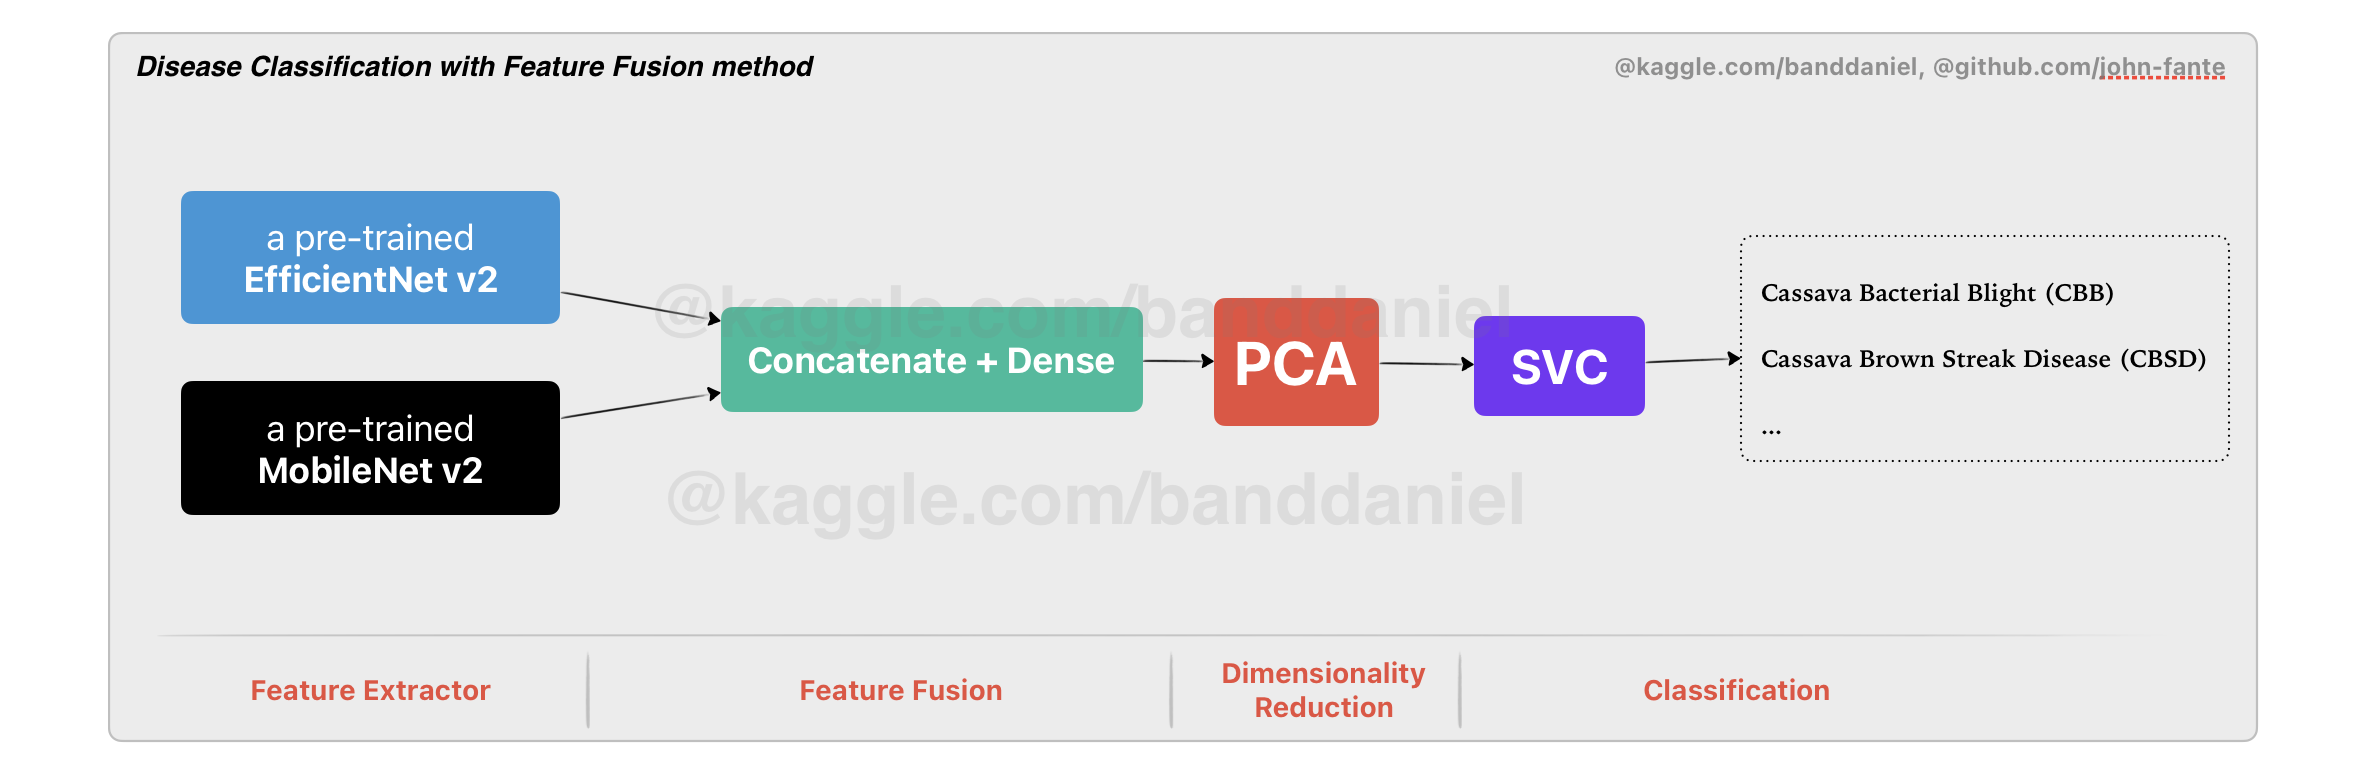
<i>Figure 1: proposed classifier</i>


<br>

* Used <b>mirrored strategy</b>,
* Used <b>tf.data</b> for input pipeline,
* I used an SVC model (with radial basis function kernel) for classification,


## My Another Projects
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Spam Mail Detection w/Tensorflow (DistilBERT)](https://www.kaggle.com/code/banddaniel/spam-mail-detection-w-tensorflow-distilbert)
* [Towards Data Science Articles Topic Modeling w/LDA](https://www.kaggle.com/code/banddaniel/towards-data-science-articles-topic-modeling-w-lda)


## References
1. Huang, C., Wang, X., Cao, J., Wang, S., & Zhang, Y. (2020). HCF: A Hybrid CNN Framework for Behavior Detection of Distracted Drivers. In IEEE Access (Vol. 8, pp. 109335–109349). Institute of Electrical and Electronics Engineers (IEEE). https://doi.org/10.1109/access.2020.3001159

In [1]:
from IPython.display import clear_output
!pip uninstall tensorflow -y
!pip install tensorflow==2.13.0
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
# A config class with several constant variables
# IMG_SIZE for the efficientnet model
# IMG_SIZE_2 for the mobilenet model

class CONFIG:
    IMG_SIZE = 300,300
    IMG_SIZE_2 = 224, 224
    BATCH_SIZE = 64
    AUTO = tf.data.AUTOTUNE
    SEED = 543

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
# Creating main dataframe contains image paths and their names
def create_images_list(path):
    full_path = []
    img_name = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        img_name.append(i)
    return full_path, img_name


img_paths, img_ids = create_images_list('/kaggle/input/crop-disease-image-classification-dataset/crop_disease_dataset/images')
real_data = pd.DataFrame({'full_img_link': img_paths, 'image_id': img_ids})


full_data_from_csv = pd.read_csv('/kaggle/input/crop-disease-image-classification-dataset/crop_disease_dataset/meta_deta.csv')

# There were not several images in the image folder, I only used images from csv file (images have same image_ids).
final_data = real_data.copy()
final_data = final_data.merge(full_data_from_csv, on ='image_id')
print('total real images \t{0}'.format(final_data.shape[0]))
final_data.head()

total real images 	17938


full_img_link        image_id  label
0  /kaggle/input/crop-disease-image-classificatio...   157078263.jpg      3
1  /kaggle/input/crop-disease-image-classificatio...  1574893536.jpg      3
2  /kaggle/input/crop-disease-image-classificatio...  1575013487.jpg      3
3  /kaggle/input/crop-disease-image-classificatio...  1576606254.jpg      0
4  /kaggle/input/crop-disease-image-classificatio...  1579761476.jpg      1

# <span style="color:#e74c3c;"> Splitting </span> Dataset

In [5]:
train_data, test_data = train_test_split(final_data, test_size = 0.3, stratify = final_data['label'], random_state = CONFIG.SEED)

# look-up table
classes = {0:"Cassava Bacterial Blight (CBB)", 1: "Cassava Brown Streak Disease (CBSD)", 2: "Cassava Green Mottle (CGM)",3:"Cassava Mosaic Disease (CMD)",4:"Healthy"}

# shuffling datasets
train_data = train_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = CONFIG.SEED).reset_index(drop = True)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	12556
total test images 	5382


In [6]:
# example of train_data file
train_data.head()

full_img_link        image_id  label
0  /kaggle/input/crop-disease-image-classificatio...  2906768430.jpg      2
1  /kaggle/input/crop-disease-image-classificatio...  2183278939.jpg      3
2  /kaggle/input/crop-disease-image-classificatio...  4048377608.jpg      2
3  /kaggle/input/crop-disease-image-classificatio...    70700352.jpg      3
4  /kaggle/input/crop-disease-image-classificatio...   270386050.jpg      1

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [7]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    
    img_efficient = tf.image.resize(img, size = (CONFIG.IMG_SIZE))
    img_efficient = tf.cast(img_efficient, tf.float32) / 255.
    
    img_mobilnet = tf.image.resize(img, size = (224,224))
    img_mobilnet = tf.cast(img_mobilnet, tf.float32) / 255.
    
    return {'efficientnet_input' :img_efficient, 'mobilenet_input':img_mobilnet}, label

In [8]:
# Creating dataset loaders and tf.datasets
# without shuffling

train_loader = tf.data.Dataset.from_tensor_slices((train_data['full_img_link'], train_data['label']))
train_dataset = (train_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO).batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['full_img_link'], test_data['label']))
test_dataset = (test_loader.map(img_preprocessing, num_parallel_calls = CONFIG.AUTO).batch(CONFIG.BATCH_SIZE).prefetch(CONFIG.BATCH_SIZE))

# <span style="color:#3498db;"> Feature Extraction </span>

In [9]:
# Creating mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

In [10]:
# Feature Fusion Model for Feature Extractor

with stg.scope():
    efficientnet =  hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-ft1k-b3-feature-vector/versions/1")
    mobilenet =  hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-feature-vector/versions/2")

    inp_efficient = Input(shape= (*CONFIG.IMG_SIZE, 3), dtype = tf.float32, name = 'efficientnet_input')
    inp_mobilenet = Input(shape= (*CONFIG.IMG_SIZE_2, 3), dtype = tf.float32, name = 'mobilenet_input')

    X1 = efficientnet(inp_efficient)
    X2 = mobilenet(inp_mobilenet)
    
    X = Concatenate(axis=1)([X1, X2])
    
    out = Dense(1024, activation='relu', name = 'the_feature_layer')(X)

    feature_extractor_model = Model([inp_efficient, inp_mobilenet], out)
    feature_extractor_model.compile(optimizer = 'adam', loss = None, metrics = None)

    feature_extractor_model.summary()

Attaching model 'google/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b3-feature-vector/1' to your Kaggle notebook...
Attaching model 'google/mobilenet-v2/tensorflow2/130-224-feature-vector/2' to your Kaggle notebook...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 efficientnet_input (InputL  [(None, 300, 300, 3)]        0         []                            
 ayer)                                                                                            
                                                                                                  
 mobilenet_input (InputLaye  [(None, 224, 224, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 keras_layer (KerasLayer)    (None, 1536)                 1293062   ['efficientnet_input[0][0]']  
                                                          2                                   

# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [11]:
# creating train features
with stg.scope():
    train_img_features = feature_extractor_model.predict(train_dataset)

197/197 [==============================] - 1590s 8s/step


In [12]:
# Applying PCA  components 790 nearly equal to 0.99 variance ratio

pca_ = PCA(790)
pca_opt = pca_.fit(train_img_features)

train_img_final_features = pca_opt.transform(train_img_features)
train_img_final_features.shape

(12556, 790)

# <span style="color:#e74c3c;"> Classification SVC </span> Model

In [13]:
X_train = train_img_final_features
y_train =  train_data['label']

In [14]:
classifier_model = SVC(kernel='rbf')

# Training SVC model with features from the feature extractor
classifier_model.fit(X_train, y_train)

SVC()

# <span style="color:#e74c3c;"> Test  </span> Results

In [15]:
# Test set processing
# test feature exteaction -> applying PCA

with stg.scope():
     test_features = feature_extractor_model.predict(test_dataset)

test_img_features = pca_opt.transform(test_features)

X_test = test_img_features
y_test =  test_data['label']

85/85 [==============================] - 677s 8s/step


In [16]:
# a function for calculating and plotting predictions 
def plot_prediction_results(model, X_data, y_data, target_names = list(classes.values())):
    pred = model.predict(X_data)
    
    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)
    
    clf = classification_report(y_data, pred, target_names = target_names)
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, xticks_rotation="vertical", colorbar = False)

Mean Squared Error :	0.87978
Weighted F1 Score :	0.802
Accuracy Score :	80.936 %
----------------------------------------------------------------------

 Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.62      0.51      0.56       276
Cassava Brown Streak Disease (CBSD)       0.68      0.60      0.64       549
         Cassava Green Mottle (CGM)       0.78      0.52      0.62       598
       Cassava Mosaic Disease (CMD)       0.88      0.96      0.92      3309
                            Healthy       0.59      0.64      0.62       650

                           accuracy                           0.81      5382
                          macro avg       0.71      0.64      0.67      5382
                       weighted avg       0.80      0.81      0.80      5382

----------------------------------------------------------------------

 Confusion Matrix: 



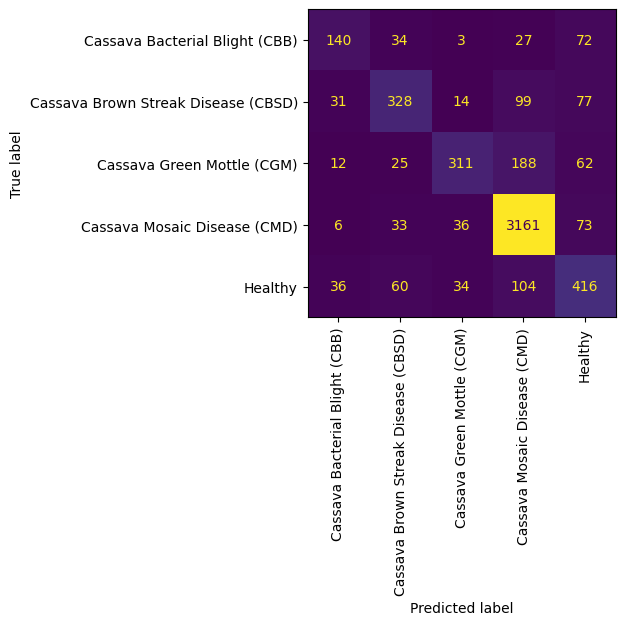

In [17]:
plot_prediction_results(classifier_model, X_test, y_test)

# <span style="color:#e74c3c;"> Test Sample</span> Prediction

In [18]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

test_pred = classifier_model.predict(X_test)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // CONFIG.BATCH_SIZE
    image_idx = idxs-batch_idx * CONFIG.BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0]['efficientnet_input'][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(test_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

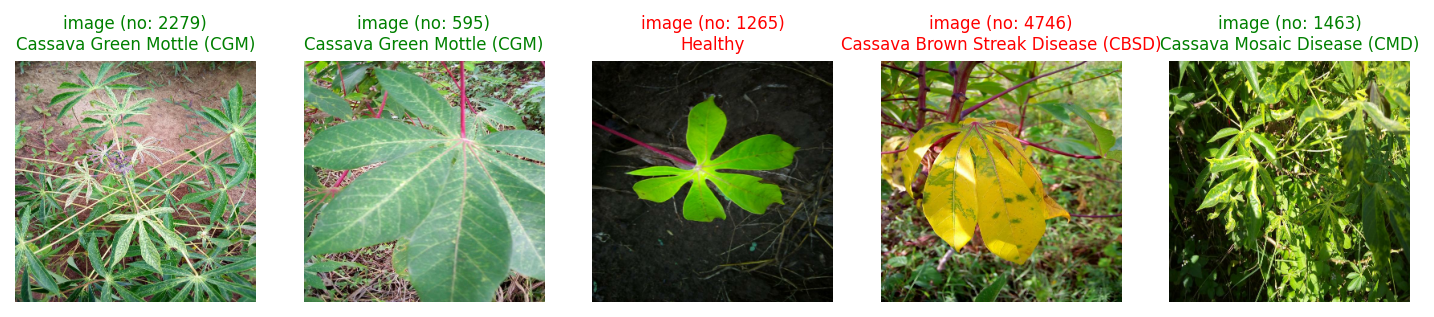

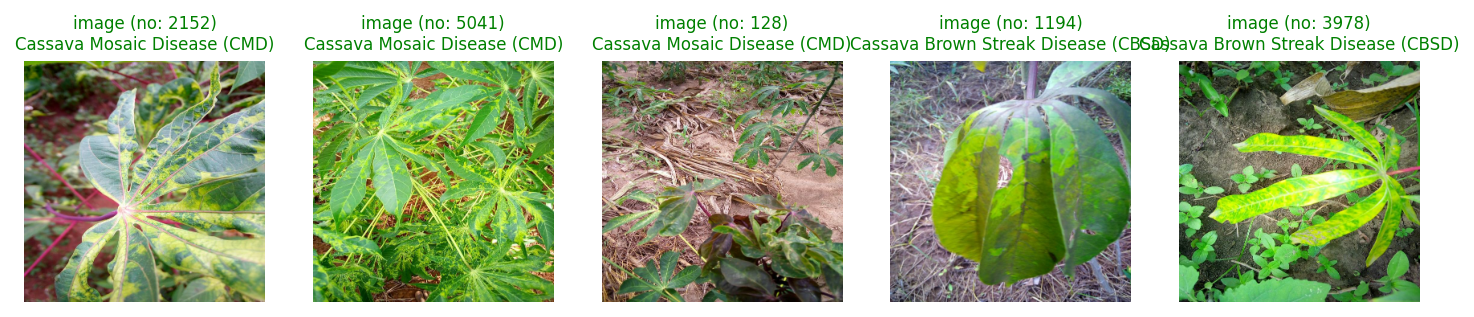

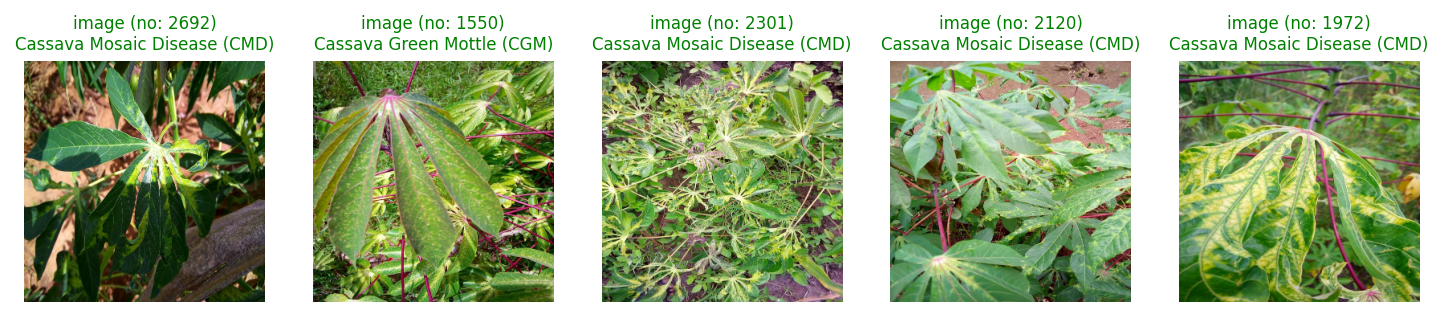

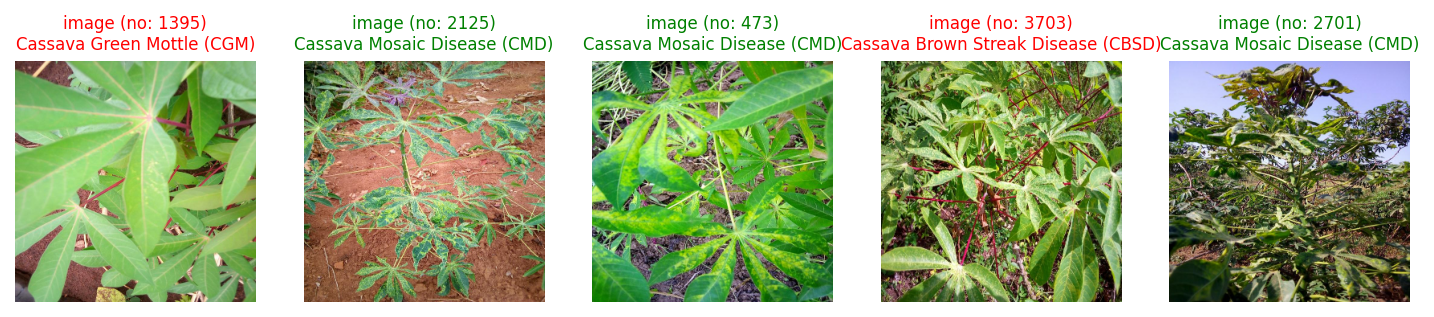

In [19]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 33)
random_test_sample_with_prediction(SEED = 515)
random_test_sample_with_prediction(SEED = 983)
random_test_sample_with_prediction(SEED = 46)